In [1]:
import pandas as pd
import numpy as np
from os import path, listdir, makedirs
from scipy.stats import rankdata, ranksums
import matplotlib.pyplot as plt
import shutil
from scipy.stats import hypergeom, norm

In [2]:
MIN_GENE_PER_PATHWAY = 20
MAX_GENE_PER_PATHWAY = 200
FDR_THRESHOLD = 0.05
JAC_THRESHOLD = 0.2
P_VALUE_THRESHOLD = 0.05
root_path = '/mnt/c/Users/pickh/PycharmProjects/Yair_propagation'
output_path = path.join(root_path, 'Outputs')
Experiment_name = 'Parkinson'
data_file = 'Data'
species = 'H_sapiens'
genes_names_file = 'H_sapiens.gene_info'
pathway_file = 'pathways'
data_dir = path.join(root_path, data_file)
input_dir = path.join(root_path, 'Inputs', 'experiments_data', Experiment_name)
genes_names_file_path = path.join(data_dir, species, 'genes_names', genes_names_file)
pathway_file_dir = path.join(data_dir, species, 'pathways', pathway_file)

temp_output_folder = path.join(root_path, 'Outputs', 'Temp')
# Ensure output directories exist
makedirs(temp_output_folder, exist_ok=True)
filtered_genes = set()

In [3]:
def load_pathways_genes():
    pathways = {}
    with open(pathway_file_dir, 'r') as f:
        for line in f:
            parts = line.strip().upper().split('\t')  # Split each line into parts
            if len(parts) < 3 or not parts[1].isdigit():
                continue

            pathway_name, pathway_size = parts[0], int(parts[1])

            genes = [int(gene) for gene in parts[2].split()[:pathway_size] if gene.isdigit()]
            pathways[pathway_name] = genes
    return pathways


def get_scores(test_name):
    # Path to the file containing the raw scores (adjust as necessary)
    raw_scores_file_path = path.join(input_dir, f'{test_name}.csv')

    try:
        # Load raw data from the file
        raw_data = pd.read_csv(raw_scores_file_path, usecols=['GeneID', 'Score', 'P-value'])
        # Assuming 'GeneID' and 'Score' are columns in the raw data
        raw_data.sort_values(by='GeneID', inplace=True)

        # Create a dictionary for gene_id_to_score using vectorized operations
        scores_dict = raw_data.set_index('GeneID')[['Score', 'P-value']].to_dict()
        return scores_dict

    except FileNotFoundError:
        print(f"File not found: {raw_scores_file_path}")
        return pd.DataFrame(), {}
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame(), {}

In [4]:
def hypergeometric_sf(x, M, N, n):
    """Calculate the probability mass function for the hypergeometric distribution.
    :param x: the number of successes in the sample
    :param M: the total number of objects
    :param N: the total number of Type I objects
    :param n: the number of sampled objects
    :return: the probability mass function for the hypergeometric distribution"""
    # use scipy.stats.hypergeom
    probability = hypergeom.sf(x-1, M, N, n)
    return probability

In [5]:
def bh_correction(p_values):
    p_vals_rank = rankdata(p_values, 'max') - 1
    p_vals_rank_ord = rankdata(p_values, 'ordinal') - 1

    p_values_sorted = np.zeros_like(p_vals_rank)
    p_values_sorted[p_vals_rank_ord] = np.arange(len(p_vals_rank_ord))

    p_vals = p_values * (len(p_values) / (p_vals_rank + 1))
    adj_p_vals_by_rank = p_vals[p_values_sorted]

    p_vals_ordered = np.minimum(adj_p_vals_by_rank, np.minimum.accumulate(adj_p_vals_by_rank[::-1])[::-1])
    adj_p_vals = p_vals_ordered[p_vals_rank]
    return adj_p_vals

In [6]:
def perform_statist(test_name):
    scores = get_scores(test_name)
    significant_p_vals = {gene_id: p_value for gene_id, p_value in scores['P-value'].items() if p_value < 0.05}
    scores_keys = set(scores['Score'].keys())

    pathways_with_many_genes = {
        pathway: set(genes).intersection(scores_keys)
        for pathway, genes in genes_by_pathway.items()
        if MIN_GENE_PER_PATHWAY <= len(set(genes).intersection(scores_keys)) <= MAX_GENE_PER_PATHWAY
    }

    for pathway, genes in pathways_with_many_genes.items():
        filtered_genes.update(genes)


    M = len(scores_keys)  # Total number of genes
    n = len(significant_p_vals)  # Number of enriched genes

    hypergeom_p_values = []
    pathway_names = []

    for pathway_name, pathway_genes in pathways_with_many_genes.items():
        N = len(pathway_genes)  # Number of genes in the pathway
        x = len(set(pathway_genes).intersection(set(significant_p_vals.keys())))  # Number of enriched genes in the pathway
        pval = hypergeometric_sf(x, M, N, n) if x >= 5 else 1
        hypergeom_p_values.append(pval)
        pathway_names.append(pathway_name)

    # Filter pathways based on hypergeometric p-values
    significant_pathways = [
        pathway for i, pathway in enumerate(pathway_names) if hypergeom_p_values[i] < 0.05
    ]

    ks_p_values = []
    for pathway in significant_pathways:
        genes = pathways_with_many_genes[pathway]
        pathway_scores = [scores['Score'][gene_id] for gene_id in genes if gene_id in scores['Score']]
        background_genes = scores_keys - genes
        background_scores = [scores['Score'][gene_id] for gene_id in background_genes]
        ks_p_values.append(kolmogorov_smirnov_test(pathway_scores, background_scores))

    # Apply BH correction to KS p-values
    adjusted_p_values = bh_correction(np.array(ks_p_values))

    # Filter significant pathways based on adjusted KS p-values
    ks_significant_pathways_with_genes = {
        pathway: (pathways_with_many_genes[pathway], adjusted_p_values[i])
        for i, pathway in enumerate(significant_pathways)
        if adjusted_p_values[i] < 0.05
    }

    return ks_significant_pathways_with_genes, scores

In [7]:
def perform_statist_mann_whitney(passed_ks_pathway_dict, scores):
    mw_p_values = []
    significant_pathways_with_genes = {}

    scores_keys = set(scores['Score'].keys())
    # rank the scores of filtered genes and turn it into a dict of gene_id: rank
    scores_rank = {gene_id: rank for gene_id, rank in zip(scores_keys, rankdata([scores['Score'][gene_id] for gene_id in scores_keys]))}

    # Mann-Whitney U test and FDR
    for pathway, genes_info in passed_ks_pathway_dict.items():
        pathway_genes = set(genes_info[0])
        pathway_scores = [scores['Score'][gene_id] for gene_id in pathway_genes]
        background_scores = [scores['Score'][gene_id] for gene_id in filtered_genes - pathway_genes]

        pathway_ranks = [scores_rank[gene_id] for gene_id in pathway_genes]
        background_ranks = [scores_rank[gene_id] for gene_id in filtered_genes - pathway_genes]
        # Perform Mann-Whitney U Test
        mw_pval = wilcoxon_rank_sums_test(pathway_scores, background_scores)
        _, rmw_pval = compute_mw_python(pathway_scores, background_scores, pathway_ranks, background_ranks)
        mw_p_values.append(mw_pval)


    # Apply BH correction to Mann-Whitney p-values
    adjusted_mw_p_values = bh_correction(np.array(mw_p_values))

    filtered_pathways = []
    for i, (pathway, genes) in enumerate(passed_ks_pathway_dict.items()):
        if adjusted_mw_p_values[i] < 0.05:  # Significance threshold
            significant_pathways_with_genes[pathway] = genes
            filtered_pathways.append({
                'Pathway': pathway,
                'Adjusted_p_value': adjusted_mw_p_values[i],
                'Genes': genes[0]
            })

    # Convert filtered pathways to a DataFrame
    pathways_df = pd.DataFrame(filtered_pathways)
    pathways_df.sort_values(by='Adjusted_p_value', inplace=True)

    # Filter pathways based on Jaccard index
    filtered_pathways = {}
    for i, row in pathways_df.iterrows():
        current_genes = set(row['Genes'])
        if not any(jaccard_index(current_genes, set(filtered_row['Genes'])) > JAC_THRESHOLD
                   for filtered_row in filtered_pathways.values()):
            filtered_pathways[row['Pathway']] = row

    return filtered_pathways

In [8]:
def jaccard_index(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

In [9]:
def kolmogorov_smirnov_test(experiment_scores, control_scores):
    # Convert lists to numpy arrays and sort
    experiment_scores = np.sort(experiment_scores)
    control_scores = np.sort(control_scores)
    # Initialize variables
    en1 = len(experiment_scores)
    en2 = len(control_scores)

    # Calculate empirical cumulative distribution functions for both sets
    data_all = np.concatenate([experiment_scores, control_scores])
    cdf_experiment = np.searchsorted(experiment_scores, data_all, side='right') / en1
    cdf_control = np.searchsorted(control_scores, data_all, side='right') / en2

    # Find the maximum distance
    D = np.max(np.abs(cdf_experiment - cdf_control))
    # Calculate the KS statistic
    en = np.sqrt(en1 * en2 / (en1 + en2))
    p_value = ks((en + 0.12 + 0.11 / en) * D)

    return p_value


def ks(alam):
    EPS1 = 1e-6  # Convergence criterion based on the term's absolute value
    EPS2 = 1e-10  # Convergence criterion based on the sum's relative value
    a2 = -2.0 * alam ** 2  # Squared and negated lambda for exponential calculation
    fac = 2.0
    sum = 0.0
    termbf = 0.0

    # Iteratively calculate the KS probability
    for j in range(1, 101):
        term = fac * np.exp(a2 * j ** 2)  # Calculate term of the series
        sum += term  # Add to sum

        # Check for convergence
        if np.abs(term) <= EPS1 * termbf or np.abs(term) <= EPS2 * sum:
            return sum

        fac = -fac  # Alternate the sign
        termbf = np.abs(term)  # Update term before flag

    # Return 1.0 if the series does not converge in 100 terms
    return 1.0

In [10]:
def wilcoxon_rank_sums_test(experiment_scores, elements_scores, alternative='two-sided'):
    p_vals = ranksums(experiment_scores, elements_scores, alternative=alternative).pvalue
    return p_vals


def compute_mw_python(experiment_scores, control_scores, experiment_ranks2, control_ranks2):
    # Combine the two arrays and sort them
    combined_scores = np.concatenate([experiment_scores, control_scores])
    ranks = np.argsort(np.argsort(combined_scores)) + 1  # Compute ranks
    # print the highest rank
    print(ranks[-1])
    # Identify the ranks for the experiment and control groups
    experiment_ranks = ranks[:len(experiment_scores)]
    control_ranks = ranks[len(experiment_scores):]

    # Calculate the rank sums for the experiment and control groups
    R1 = np.sum(experiment_ranks)
    R12 = np.sum(experiment_ranks2)
    R2 = np.sum(control_ranks)

    # Number of observations in each group
    n1 = len(experiment_scores)
    n2 = len(control_scores)

    # Calculate the U statistic for each group
    U1 = R1 - n1*(n1+1)/2
    U2 = R2 - n2*(n2+1)/2

    # Choose the smaller U value for the test statistic
    U = min(U1, U2)

    # Calculate the mean and standard deviation of U distribution
    mean_U = n1*n2/2
    std_U = np.sqrt(n1*n2*(n1+n2+1)/12)

    # Compute the Z-score
    Z = (U - mean_U) / std_U

    # Compute the p-value
    p_value = 2 * norm.cdf(-np.abs(Z))

    return U, p_value

In [11]:
def print_enriched_pathways_to_file(filtered_pathways, output_folder, threshold=0.05):
    output_file_path = path.join(output_folder, f'{test_name}.txt')
    significant_count = 0

    with open(output_file_path, 'w') as file:
        for pathway, details in filtered_pathways.items():
            p_value = details.get('Adjusted_p_value')
            if p_value and p_value < threshold:
                file.write(f"{pathway} {p_value}\n")
                significant_count += 1

In [12]:
def read_scores(file_name):
    """Reads scores from a given file into a dictionary."""
    return pd.read_csv(file_name, sep=' ', header=None, names=['Pathway', 'Score'], index_col='Pathway')[
        'Score'].to_dict()

In [13]:
def read_pathways(file_name):
    """Reads pathways from a given file into a dictionary."""
    with open(file_name, 'r') as file:
        return {line.split()[0]: [int(gene) for gene in line.split()[2:]] for line in file}

In [27]:
def process_condition(condition_file, experiment_file, pathways_file):
    """Processes an experiment and returns scores, enriched pathway genes, and mean scores."""
    enriched_pathway_dict = read_scores(condition_file)
    condition_data_df = pd.read_csv(experiment_file)
    condition_data_df_filtered = condition_data_df[condition_data_df['Score'] != 0]
    condition_name = path.basename(condition_file).split('.')[-1]
    homo_sapien_pathway_dict = read_pathways(pathways_file)
    enriched_pathway_genes = {}

    for pathway in all_pathways:
        all_pathways[pathway][condition_name] = {}
        pathway_genes = homo_sapien_pathway_dict[pathway]
        filtered_genes = condition_data_df_filtered[condition_data_df_filtered['GeneID'].isin(pathway_genes)]
        enriched_pathway_genes[pathway] = filtered_genes.set_index('GeneID')[['Symbol', 'Score', 'P-value']].to_dict(
            orient='index')
        significant_genes = {gene_id: gene_details for gene_id, gene_details in
                             enriched_pathway_genes[pathway].items() if
                             gene_details['P-value'] <= P_VALUE_THRESHOLD}
        if significant_genes:
            mean_score = np.mean([gene_details['Score'] for gene_details in significant_genes.values()])
        else:
            mean_score = 0
        all_pathways[pathway][condition_name]['Mean'] = mean_score
        # Assign significant genes to the pathway in all_pathways
        all_pathways[pathway][condition_name]['significant_genes'] = significant_genes
        if pathway in enriched_pathway_dict.keys():
            all_pathways[pathway][condition_name]['P-value'] = enriched_pathway_dict[pathway]
            all_pathways[pathway][condition_name]['Trend'] = "Up*" if mean_score > 0 else "Down*"
        else:
            all_pathways[pathway][condition_name]['P-value'] = 1
            # Filter genes based on p-value threshold
            all_pathways[pathway][condition_name]['Trend'] = "Up" if mean_score > 0 else "Down"

In [15]:
def bold_keywords(text, keywords):
    """Returns text with keywords in bold."""
    for keyword in keywords:
        if keyword in text:
            text = text.replace(text, f"**{text}**")
    return text

In [16]:
def print_aggregated_pathway_information(output_dir, experiment_name):
    file_path = os.path.join(output_dir, 'Text', f'{experiment_name}_aggregated.txt')

    # Create a list of (pathway, best_p_value) tuples
    pathways_p_values = []
    for pathway, conditions in all_pathways.items():
        best_p_value = min(condition_data['P-value'] for condition_data in conditions.values())
        pathways_p_values.append((pathway, best_p_value))

    # Sort pathways by best p-value
    pathways_sorted = sorted(pathways_p_values, key=lambda x: x[1])

    with open(file_path, 'w') as file:
        for pathway, best_p_value in pathways_sorted:
            file.write(f"Pathway: {pathway} {best_p_value}\n")

            # Aggregate and write trends for all conditions
            trends = [f"{condition_name}: {all_pathways[pathway][condition_name]['Trend']}" for condition_name in
                      all_pathways[pathway]]
            file.write(f"Trends: {', '.join(trends)}\n")

            # Aggregate and write significant genes across all conditions
            file.write("Significant Genes:\n")
            gene_scores_across_conditions = {}
            for condition_name, condition_data in all_pathways[pathway].items():
                for gene_id, gene_info in condition_data.get('significant_genes', {}).items():
                    if gene_id not in gene_scores_across_conditions:
                        gene_scores_across_conditions[gene_id] = {'Symbol': gene_info['Symbol'], 'Scores': []}
                    gene_scores_across_conditions[gene_id]['Scores'].append(gene_info['Score'])

            for gene_id, gene_data in gene_scores_across_conditions.items():
                scores_str = ', '.join(map(str, gene_data['Scores']))
                file.write(f"    {gene_data['Symbol']}: {scores_str}\n")

            file.write("\n")

In [17]:
def plot_pathways_mean_scores(output_dir, experiment_name):
    """Plots mean scores of pathways across experiments in a horizontal bar chart."""

    mean_scores_data = {}
    p_values_data = {}
    for pathway, conditions in all_pathways.items():
        for condition_name, condition_data in conditions.items():
            mean_scores_data.setdefault(condition_name, {})[pathway] = condition_data.get('Mean', 0)
            p_values_data.setdefault(condition_name, {})[pathway] = condition_data.get('P-value', 1)

    data_df = pd.DataFrame(mean_scores_data)
    p_values_df = pd.DataFrame(p_values_data)

    # Increase the figure size significantly
    plt.figure(figsize=(20, 60))  # Adjust the size as needed
    ax = plt.subplot(111)

    conditions = list(mean_scores_data.keys())
    total_pathways = data_df.index
    num_conditions = len(conditions)
    bar_height = 0.8 / num_conditions
    positions = np.arange(len(total_pathways))

    # Assign colors to each condition
    colors = plt.cm.get_cmap('viridis', num_conditions)

    # Define keywords for bold formatting
    keywords = ['NEURO', 'SYNAP']

    for i, condition in enumerate(conditions):
        mean_scores = data_df[condition].values
        p_values = p_values_df[condition].values

        # Plot bars with different styles based on p-value significance
        for j, (score, p_value) in enumerate(zip(mean_scores, p_values)):
            bar_style = {"color": "white", "edgecolor": colors(i), "hatch": "//"} if p_value > P_VALUE_THRESHOLD else {"color": colors(i)}
            ax.barh(positions[j] + bar_height * i, score, height=bar_height, **bar_style)

    ax.set_yticks(positions + bar_height * (num_conditions / 2) - bar_height / 2)
    formatted_pathways = [pathway.replace('_', ' ') for pathway in total_pathways]
    ax.set_yticklabels(formatted_pathways, fontsize=12)

    for i, label in enumerate(ax.get_yticklabels()):
        if any(keyword in label.get_text().upper() for keyword in keywords):
            label.set_fontweight('bold')

    ax.set_ylabel('Pathways', fontsize=16)
    ax.set_xlabel('Mean Scores', fontsize=16)
    ax.set_title('Pathway Mean Scores Across Different Conditions', fontsize=20)

    # Create custom legends
    plt.legend([plt.Rectangle((0,0),1,1, color=colors(i)) for i in range(num_conditions)], conditions, prop={'size': 14})

    plt.subplots_adjust(left=0.4)  # Adjust for layout
    output_file_path = os.path.join(output_dir, 'Plots', f"{experiment_name}_pathway_scores.pdf")
    plt.savefig(output_file_path, format='pdf', bbox_inches='tight')
    plt.show()

In [194]:
genes_by_pathway = load_pathways_genes()
test_list = ['T_v_N', '500nm_v_T']
for test_name in test_list:
    print(f"running enrichment on {test_name}")
    significant_pathways_with_genes, scores = perform_statist(test_name)
    filtered_pathways = perform_statist_mann_whitney(significant_pathways_with_genes, scores)
    print_enriched_pathways_to_file(filtered_pathways, temp_output_folder, FDR_THRESHOLD)

running enrichment


In [18]:
print("finished enrichment")
test_file_paths = [f'{input_dir}/T_v_N.csv', f'{input_dir}/500nm_v_T.csv', f'{input_dir}/10um_v_T.csv']
import os
# Extract the test names from the file paths to match them with condition files
# test_names = [os.path.splitext(os.path.basename(path))[0] for path in test_file_paths]


# Get the list of condition files
# condition_files_unsorted = [os.path.join(temp_output_folder, file) for file in os.listdir(temp_output_folder)]

# Sort condition_files based on the order of test_names
# condition_files = sorted(condition_files_unsorted, key=lambda x: test_names.index(os.path.splitext(os.path.basename(x))[0]))
condition_files = ['Outputs/Temp/TvN', 'Outputs/Temp/500vT', 'Outputs/Temp/10vT']

finished enrichment


In [28]:
all_pathways = {}
for condition_file in condition_files:
    enriched_pathway_dict = read_scores(condition_file)
    condition_name = path.basename(condition_file).split('.')[-1]
    for pathway in enriched_pathway_dict.keys():
        if pathway not in all_pathways:
            all_pathways[pathway] = {}
# Processing and aggregating data
for condition_file, experiment_file in zip(condition_files, test_file_paths):
    process_condition(condition_file, experiment_file, pathway_file_dir)

/tmp/ipykernel_363/2534238277.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_conditions)


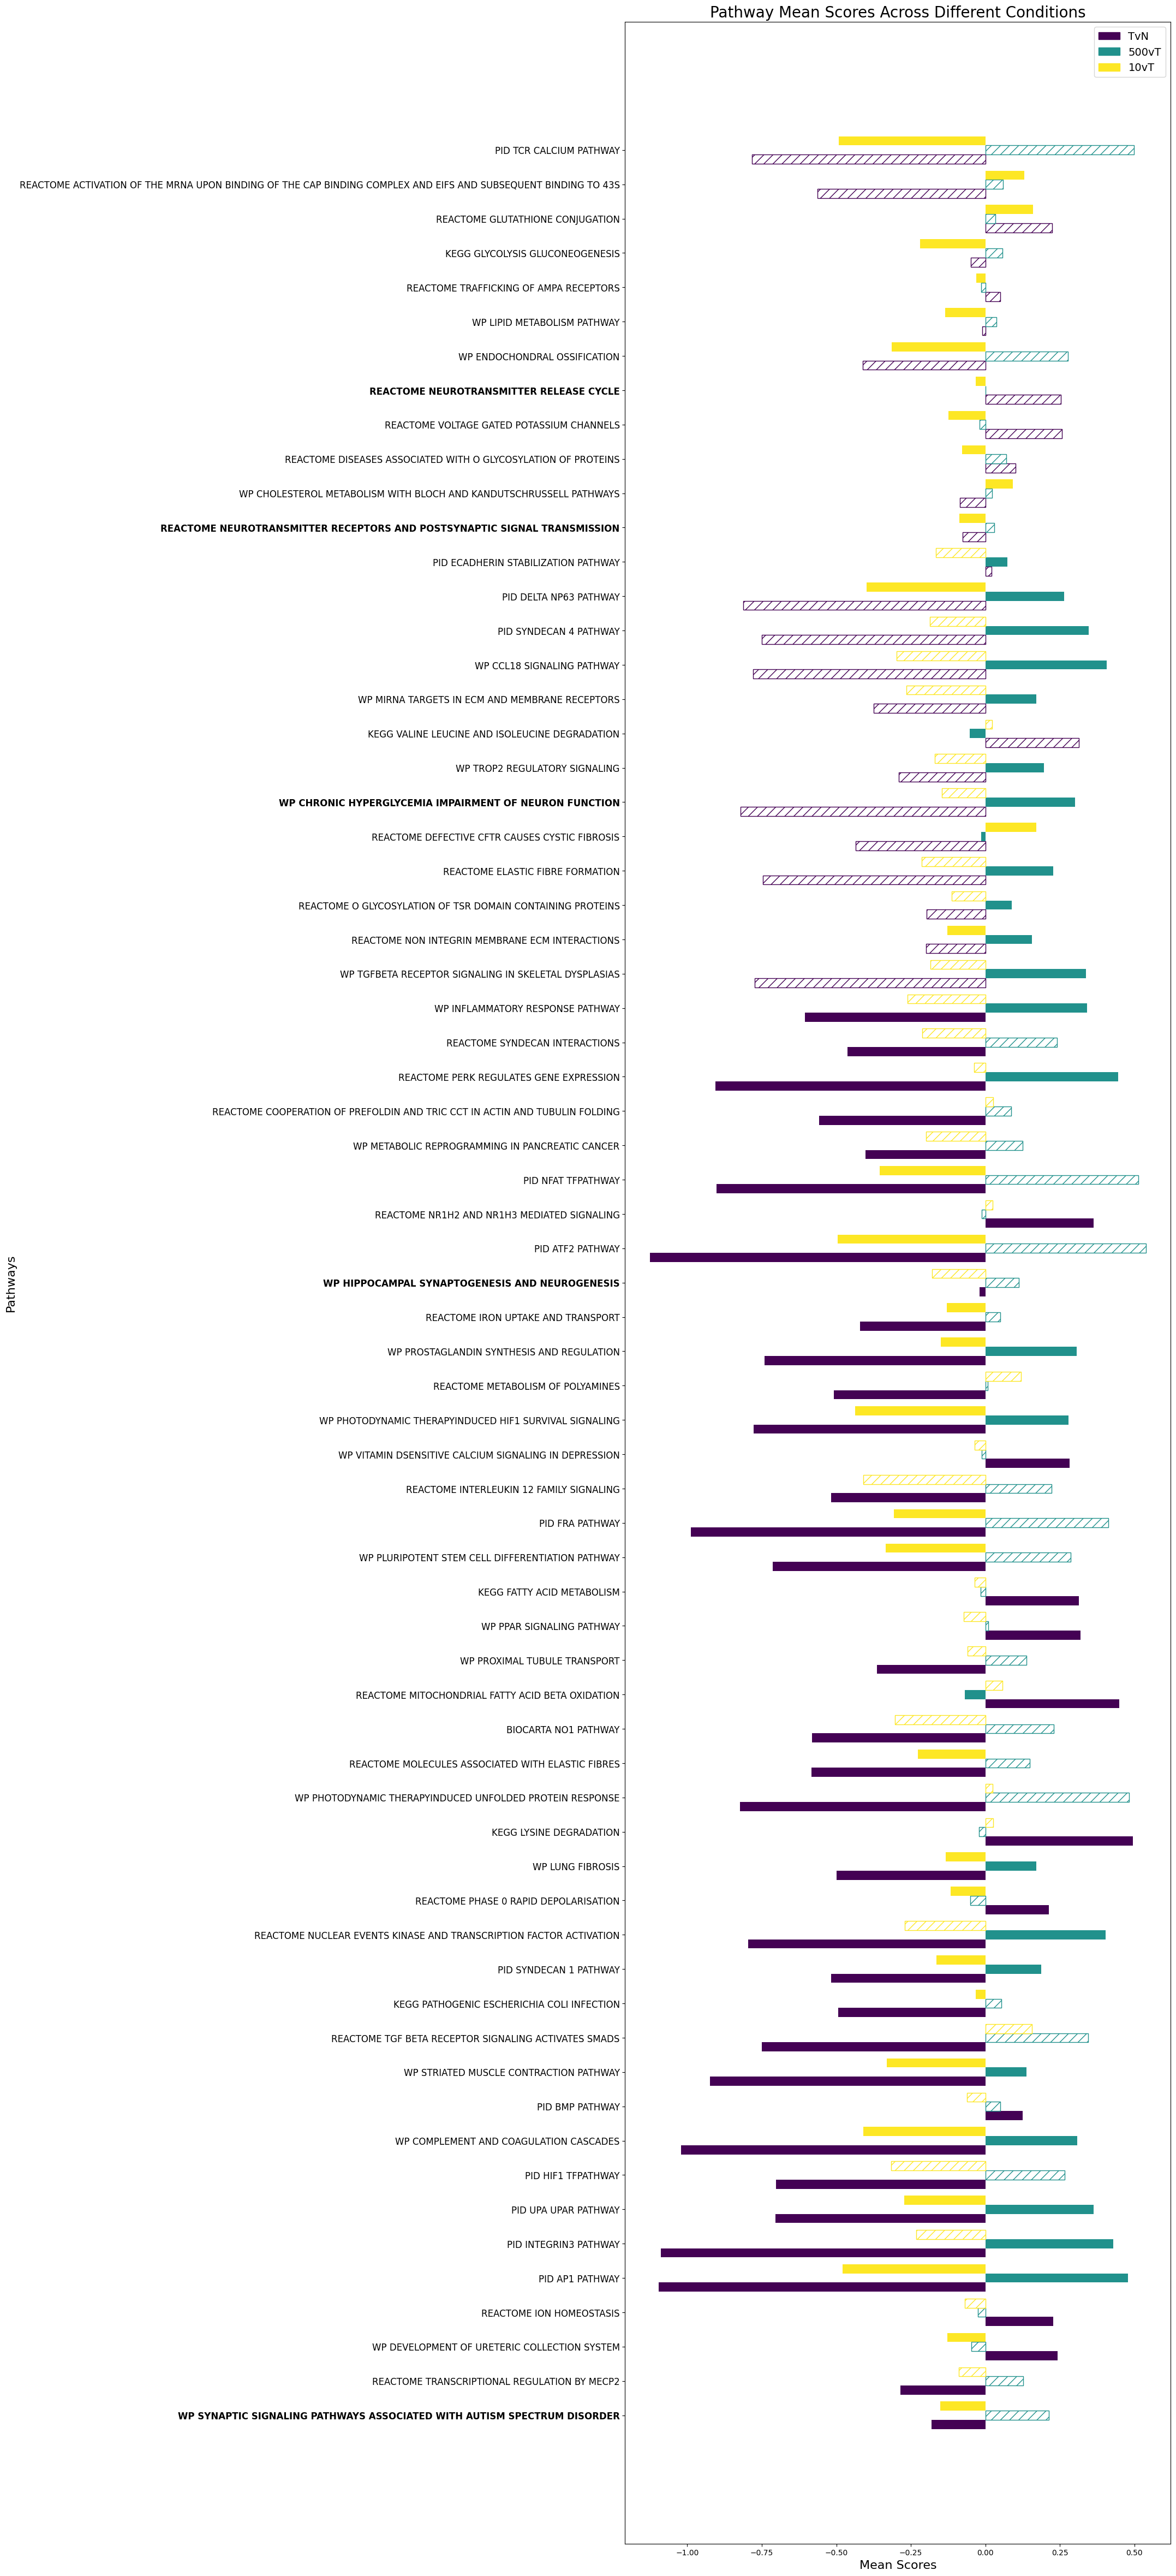

In [29]:
# Print aggregated pathway information
print_aggregated_pathway_information(output_path, Experiment_name)

# Plot the mean scores
plot_pathways_mean_scores(output_path, Experiment_name)

In [203]:
# Clean up the output folder if it exists
if path.exists(temp_output_folder):
    shutil.rmtree(temp_output_folder)